# Kaggle Titanic survival - Dealing with imbalanced data by enhancing the minority class with synthetic data (SMOTE: Synthetic Minority Over-sampling Technique)


A problem with machine learning models is that they may end up biased towards the majority class, and under-predict the minority class(es).

Some models (including sklearn's logistic regression) allow for thresholds of classification to be changed. This can help rebalance classification in models, especially where there is a binary classification (e.g. survived or not).

Here we create a more imbalanced data set from the Titanic set, by dropping half the survivors.

We then enhance the minority class with synthetic data using a technique called Synthetic Minority Over-sampling Technique (SMOTE). Essentially, SMOTE creates new cases by interpolating between two existing near-neighbough cases. SMOTE rebalances the data set, synthetically enhancing the minority class so that the number of minority examples are increased to match the number of majority samples.

We will use a package, imblearn, for this method. You may install with with: `pip install -U imbalanced-learn`, or `conda install -c conda-forge imbalanced-learn`.

We will use the `SMOTENC` method as that allows us to create synthetic data where some of the fields are categorical, rather than continuous, data. For categorical data, this method identifies *k* nearest neighbours and sets a feature label as the most common value among those near neighbours.

More on imblearn here: https://imbalanced-learn.org/stable/

*Reference*

N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 16, 321-357, 2002

In this notebook we will:
* Fit a model without SMOTE
* Fit a model with SMOTE
* Fine-tune SMOTE to correctly predict the proportion of passengers surviving

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Artificially reduce the number of survivors (to make data set more imbalanced)

In [6]:
# Shuffle original data
data = data.sample(frac=1.0) # Sampling with a fraction of 1.0 shuffles data

# Create masks for filters
mask_died = data['Survived'] == 0
mask_survived = data['Survived'] == 1

# Filter data
died = data[mask_died]
survived = data[mask_survived]

# Reduce survived by half
survived = survived.sample(frac=0.5)

# Recombine data and shuffle
data = pd.concat([died, survived])
data = data.sample(frac=1.0) 

# Show average of survived
survival_rate = data['Survived'].mean()
print ('Proportion survived:', np.round(survival_rate,3))

Proportion survived: 0.238


## Define function to standardise data

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Define function to measure accuracy

The following is a function for multiple accuracy measures.

In [8]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [9]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Set up DataFrame to hold results`

In [10]:
results_names = ['accuracy', 'precision', 'recall', 'f1', 
                 'predicted positive rate', 'observed positive rate']

results = pd.DataFrame(index = results_names)

## Convert data from Pandas DataFrame to NumPy

This is required for k-fold validation.

If you are unfamiliar with k-fold validation please see:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

In [11]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

## Logistic regression without SMOTE

In [12]:
# Set up lists to hold results for each k-fold run
replicate_accuracy = []
replicate_precision = []
replicate_recall = []
replicate_f1 = []
replicate_predicted_positive_rate = []
replicate_observed_positive_rate = []

# Set up splits
number_of_splits = 10
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
for train_index, test_index in skf.split(X_np, y_np):
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train)
    
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    
    # Predict test set labels and get accuracy scores
    y_pred_test = model.predict(X_test_std)
    accuracy_scores = calculate_accuracy(y_test, y_pred_test)
    replicate_accuracy.append(accuracy_scores['accuracy'])
    replicate_precision.append(accuracy_scores['precision'])
    replicate_recall.append(accuracy_scores['recall'])
    replicate_f1.append(accuracy_scores['f1'])
    replicate_predicted_positive_rate.append(
        accuracy_scores['predicted_positive_rate'])
    replicate_observed_positive_rate.append(
        accuracy_scores['observed_positive_rate'])
    
# Transfer results to list and add to data frame
non_smote_results = [np.mean(replicate_accuracy),
                     np.mean(replicate_precision),
                     np.mean(replicate_recall),
                     np.mean(replicate_f1),
                     np.mean(replicate_predicted_positive_rate),
                     np.mean(replicate_observed_positive_rate)]

results['non_smote'] = non_smote_results

print (results)

                        non_smote
accuracy                 0.854167
precision                0.776072
recall                   0.562092
f1                       0.643747
predicted positive rate   0.175000
observed positive rate   0.237500


## Logistic regression with SMOTE

### Create an array to show which features are categorical
In our data set only age and fare are continuous variables. All the other are categorical - that is they are one of a list of descrete values.

So we shall create a series from feature names, set all of then original to categorical, and then change age and fair to categorical.

In [13]:
# Create an array of ones for all features
number_of_features = X.shape[1]
categorical_array = np.ones(number_of_features)

# Create list of non-categorigcal features
non_cat = ['Age','Fare']

# Assign non_categorical features in our 'categorical' array
features = list(X)
for index, feature in enumerate(features):
    if feature in non_cat:
        print ('Set {:} to non-categorical'.format(feature))
        categorical_array[index] = 0
 
# Get catagorical indices
categorical = np.where(categorical_array == 1)[0]

# Print our categorical array
print ('Categorical features')
print (categorical)

Set Age to non-categorical
Set Fare to non-categorical
Categorical features
[ 0  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


### Run model

Convert X & y to NumPy arrays (required for k-fold stratification)

In [14]:
X_np = X.values
y_np = y.values

Fit logistic regression model (including SMOTE expansion of training set)

In [15]:
from imblearn.over_sampling import SMOTENC # Use SMOTE for continuous data

# Set up lists to hold results for each k-fold run
replicate_accuracy = []
replicate_precision = []
replicate_recall = []
replicate_f1 = []
replicate_predicted_positive_rate = []
replicate_observed_positive_rate = []

# Set up splits
number_of_splits = 10
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
for train_index, test_index in skf.split(X_np, y_np):
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Create an enhanced data set with SMOTENC
    smote_nc = SMOTENC(categorical_features=categorical, random_state=42)
    X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_resampled, X_test)
    
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std, y_resampled)
    
    # Predict training and test set labels
    y_pred_train = model.predict(X_train_std)
    y_pred_test = model.predict(X_test_std)
    
    # Predict test set labels and get accuracy scores
    y_pred_test = model.predict(X_test_std)
    accuracy_scores = calculate_accuracy(y_test, y_pred_test)
    replicate_accuracy.append(accuracy_scores['accuracy'])
    replicate_precision.append(accuracy_scores['precision'])
    replicate_recall.append(accuracy_scores['recall'])
    replicate_f1.append(accuracy_scores['f1'])
    replicate_predicted_positive_rate.append(
        accuracy_scores['predicted_positive_rate'])
    replicate_observed_positive_rate.append(
        accuracy_scores['observed_positive_rate'])
    
# Transfer results to list and add to data frame
non_smote_results = [np.mean(replicate_accuracy),
                     np.mean(replicate_precision),
                     np.mean(replicate_recall),
                     np.mean(replicate_f1),
                     np.mean(replicate_predicted_positive_rate),
                     np.mean(replicate_observed_positive_rate)]

results['smote'] = non_smote_results

print (results)

                        non_smote     smote
accuracy                 0.854167  0.811111
precision                0.776072  0.590665
recall                   0.562092  0.702288
f1                       0.643747  0.637948
predicted positive rate   0.175000  0.284722
observed positive rate   0.237500  0.237500


## Observations

* Accuracy is highest with non-enhanced data
* The minority class is under-predicted using non-enhanced data
* Using SMOTE increases recall (detection of the minority class, the survivors), but now leads to an over-prediction of survivors.
* SMOTE is useful if detection of the minority class is important, but may lead to more false positives.
* SMOTE may be fined-tuned by passing a dictionary of the required numbers for each class. This will help to prevent a bias towards the minority class occurring. We demonstrate this below.

## Fine tuning SMOTE

By default, SMOTE rebalances the data set, synthetically enhancing the minority class so that the number of minority examples are increased to match the number of majority samples. Following on from the observation above that SMOTE may over-compensate and lead to over-estimation of the occurrence of the minority class, here we will fine-tune SMOTE by passing a dictionary of values for both the majority class (died), and the minority class (died). We will fix SMOTE to return 500 passengers who died, and vary the number of passengers who survived.

In [16]:
### Build a list of alternative balances of died:survived

In [17]:
smote_alterantive_samples = []
survived_sample_sizes = list(range(150, 501, 50))

for sample_size in survived_sample_sizes:
    smote_input = dict()
    smote_input[0] = 500 # always have 500 died passengers in retruened sample
    smote_input[1] = sample_size
    smote_alterantive_samples.append(smote_input)
    
# Show resulting list
print (smote_alterantive_samples)

[{0: 500, 1: 150}, {0: 500, 1: 200}, {0: 500, 1: 250}, {0: 500, 1: 300}, {0: 500, 1: 350}, {0: 500, 1: 400}, {0: 500, 1: 450}, {0: 500, 1: 500}]


### Run SMOTE with alternative sampling schemas

In [18]:
# Create NumPy arrays of X and y (required for k-fold)
X_np = X.values
y_np = y.values

# Create lists for overall results

results_accuracy = []
results_precision = []
results_recall = []
results_f1 = []
results_predicted_positive_rate = []
results_observed_positive_rate = []

# Loop through list of alternative SMOTE sample sizes

for sample_dict in smote_alterantive_samples:
    
    # Create lists for k-fold results
    kfold_accuracy = []
    kfold_precision = []
    kfold_recall = []
    kfold_f1 = []
    kfold_predicted_positive_rate = []
    kfold_observed_positive_rate = []
    
    # Set up k-fold training/test splits
    number_of_splits = 5
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y_np)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):

        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_np[train_index], y_np[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        
        # Create an enhanced data set with SMOTENC
        smote_nc = SMOTENC(categorical_features=categorical, 
                           sampling_strategy=sample_dict,
                           random_state=42)
        X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_resampled, X_test)

        # Set up and fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std, y_resampled)
 
        # Predict test set labels and get accuracy scores
        y_pred_test = model.predict(X_test_std)
        accuracy_scores = calculate_accuracy(y_test, y_pred_test)
        kfold_accuracy.append(accuracy_scores['accuracy'])
        kfold_precision.append(accuracy_scores['precision'])
        kfold_recall.append(accuracy_scores['recall'])
        kfold_f1.append(accuracy_scores['f1'])
        kfold_predicted_positive_rate.append(
            accuracy_scores['predicted_positive_rate'])
        kfold_observed_positive_rate.append(
            accuracy_scores['observed_positive_rate'])
                        
    # Add mean results to overall results
    results_accuracy.append(np.mean(kfold_accuracy))
    results_precision.append(np.mean(kfold_precision))
    results_recall.append(np.mean(kfold_recall))
    results_f1.append(np.mean(kfold_f1))
    results_predicted_positive_rate.append(
        np.mean(kfold_predicted_positive_rate))
    results_observed_positive_rate.append(
        np.mean(kfold_observed_positive_rate))

# Transfer results to dataframe
results = pd.DataFrame(survived_sample_sizes, columns=['sample_size'])
results['accuracy'] = results_accuracy
results['precision'] = results_precision
results['recall'] = results_recall
results['f1'] = results_f1
results['predicted_positive_rate'] = results_predicted_positive_rate
results['observed_positive_rate'] = results_observed_positive_rate

In [19]:
results

,sample_size,accuracy,precision,recall,f1,predicted_positive_rate,observed_positive_rate
0,150,0.848611,0.753090,0.550252,0.632081,0.175000,0.2375
1,200,0.841667,0.689584,0.620168,0.649474,0.215278,0.2375
2,250,0.840278,0.670522,0.661345,0.662391,0.236111,0.2375
3,300,0.836111,0.655294,0.678992,0.661999,0.248611,0.2375
4,350,0.834722,0.644504,0.702353,0.668622,0.261111,0.2375
5,400,0.827778,0.630362,0.702353,0.659806,0.268056,0.2375
6,450,0.819444,0.612461,0.702353,0.649153,0.276389,0.2375
7,500,0.815278,0.601037,0.708235,0.645364,0.283333,0.2375


### Plot results

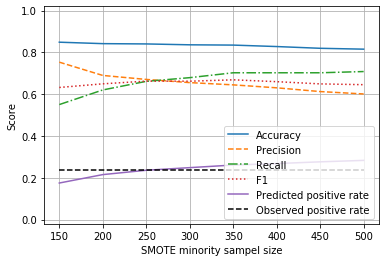

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = results['sample_size']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

plt.plot(chart_x, results['observed_positive_rate'],
         linestyle = '--',
         color='k',
         label = 'Observed positive rate')


plt.xlabel('SMOTE minority sampel size')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

From the above we can see that we can adjust the SMOTE enhancement to return 250 minority class ('survived') samples in order to balance precision and recall, and to create a model that correctly predicts the proportion of passengers surviving.